In [144]:
import sys
import os

import numpy as np
import pandas as pd

import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error


from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), ".."))) 

from src.database.base import reflect_existing_table
from src.database.session import Database
from src.utils.data import get_ph_holidays

from sqlalchemy import select
import nest_asyncio
import asyncio

nest_asyncio.apply()

async def fetch_transportation_data():
    Database.connect_async_session()
    async for session in Database.get_async_session():
        expenses_table = await reflect_existing_table("expenses")
        categories_table = await reflect_existing_table("categories")

        join_stmt = (
            select(
                expenses_table.c.date_spent,
                expenses_table.c.amount,
            )
            .select_from(
                expenses_table.join(
                    categories_table, expenses_table.c.category_id == categories_table.c.id
                )
            )
            .where(categories_table.c.name == "Transportation")
            .order_by(expenses_table.c.date_spent)
        )

        result = await session.execute(join_stmt)
        rows = result.fetchall()

        df = pd.DataFrame(rows, columns=["date_spent", "amount"])
        return df

loop = asyncio.get_event_loop()
df = loop.run_until_complete(fetch_transportation_data())

Aggregate raw daily expense data and fill missing dates

In [145]:
df["date_spent"] = pd.to_datetime(df["date_spent"]).dt.date
df["amount"] = df["amount"].astype(float)

daily_expense = df.groupby("date_spent", as_index=False).agg(
    total_amount=("amount", "sum")
)

full_date_range = pd.date_range(
    start=daily_expense["date_spent"].min(),
    end=daily_expense["date_spent"].max(),
    freq="D",
)

# Fill missing dates
daily_expense = (
    daily_expense.set_index("date_spent")
    .reindex(full_date_range)
    .rename_axis("date_spent")
    .reset_index()
)

daily_expense

,date_spent,total_amount
0,2025-08-06,120.0
1,2025-08-07,120.0
2,2025-08-08,120.0
3,2025-08-09,120.0
4,2025-08-10,45.0
...,...,...
175,2026-01-28,135.0
176,2026-01-29,105.0
177,2026-01-30,135.0
178,2026-01-31,185.0


Amount Feature

In [146]:
# Fill missing dates with 0 amount, indicating missing data -> no transportation or absent day, instead of unknown
daily_expense["total_amount"] = daily_expense["total_amount"].fillna(0.0)

daily_expense["has_spend"] = (daily_expense["total_amount"] > 0).astype(int)

Calendar Feature

In [147]:
# Calendar Features (Holiday & Weekends)
daily_expense["weekend"] = (daily_expense["date_spent"].dt.weekday == 6).astype(int)

ph_holidays = get_ph_holidays(years=daily_expense["date_spent"].dt.year.unique())

date_as_date = daily_expense["date_spent"].dt.date
daily_expense["holiday"] = date_as_date.isin(ph_holidays).astype(int)
daily_expense["holiday_name"] = date_as_date.map(ph_holidays)


daily_expense

,date_spent,total_amount,has_spend,weekend,holiday,holiday_name
0,2025-08-06,120.0,1,0,0,NaN
1,2025-08-07,120.0,1,0,0,NaN
2,2025-08-08,120.0,1,0,0,NaN
3,2025-08-09,120.0,1,0,0,NaN
4,2025-08-10,45.0,1,1,0,NaN
...,...,...,...,...,...,...
175,2026-01-28,135.0,1,0,0,NaN
176,2026-01-29,105.0,1,0,0,NaN
177,2026-01-30,135.0,1,0,0,NaN
178,2026-01-31,185.0,1,0,0,NaN


Rolling Amount Feature

In [148]:
daily_expense["rolling_mean_7d"] = (
    daily_expense["total_amount"].rolling(7, min_periods=1).mean()
)

# daily_expense["rolling_mean_14d"] = (
#     daily_expense["total_amount"].rolling(14, min_periods=1).mean()
# )

# daily_expense["rolling_mean_30d"] = (
#     daily_expense["total_amount"].rolling(30, min_periods=1).mean()
# )

daily_expense

,date_spent,total_amount,has_spend,weekend,holiday,holiday_name,rolling_mean_7d
0,2025-08-06,120.0,1,0,0,NaN,120.000000
1,2025-08-07,120.0,1,0,0,NaN,120.000000
2,2025-08-08,120.0,1,0,0,NaN,120.000000
3,2025-08-09,120.0,1,0,0,NaN,120.000000
4,2025-08-10,45.0,1,1,0,NaN,105.000000
...,...,...,...,...,...,...,...
175,2026-01-28,135.0,1,0,0,NaN,70.000000
176,2026-01-29,105.0,1,0,0,NaN,65.714286
177,2026-01-30,135.0,1,0,0,NaN,85.000000
178,2026-01-31,185.0,1,0,0,NaN,92.142857


In [149]:
daily_expense["avg_spend_per_active_day_30d"] = (
    daily_expense["total_amount"]
    .rolling(30, min_periods=1)
    .sum() / daily_expense["has_spend"]
    .rolling(30, min_periods=1)
    .sum()
    .replace(0, np.nan)
)

df = daily_expense.copy()
df["year_month"] = df["date_spent"].dt.to_period("M")
df["month_name"] = df["date_spent"].dt.strftime("%B")

monthly = df.groupby("year_month").agg(
    # month_name=("month_name", "first"),
    total_amount=("total_amount", "sum"),                     # TARGET
    active_days=("has_spend", "sum"),
    weekend_ratio=("weekend", "mean"),
    holiday_days=("holiday", "sum"),
    rolling_mean_7d=("rolling_mean_7d", "mean"),
    avg_spend_intensity=("avg_spend_per_active_day_30d", "mean"),
)

monthly

,total_amount,active_days,weekend_ratio,holiday_days,rolling_mean_7d,avg_spend_intensity
year_month,,,,,,
2025-08,1855.0,17,0.153846,2,81.405678,114.138812
2025-09,3234.0,24,0.133333,0,99.752381,125.585359
2025-10,2420.0,21,0.129032,1,80.714286,120.161962
2025-11,2627.0,22,0.166667,2,90.304762,121.730074
2025-12,2917.0,24,0.129032,5,96.193548,119.223104
2026-01,2055.0,19,0.129032,1,56.843318,106.934501
2026-02,15.0,1,1.000000,0,94.285714,106.315789


Total Amount Metrics Overtime

In [150]:
plt.rcParams["figure.figsize"] = (8, 4)

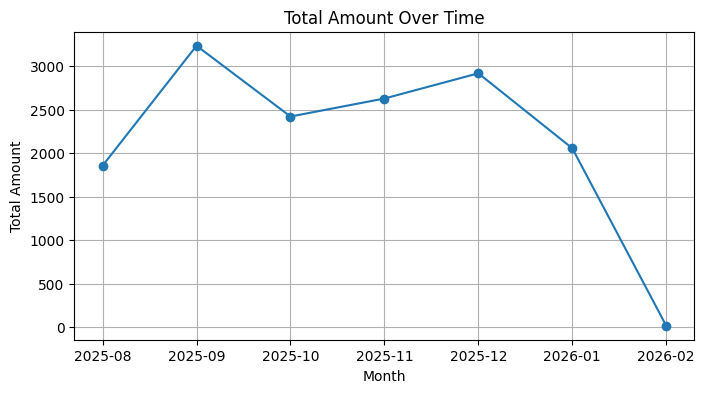

In [151]:
plt.plot(monthly.index.astype(str), monthly["total_amount"], marker="o")
plt.title("Total Amount Over Time")
plt.xlabel("Month")
plt.ylabel("Total Amount")
plt.grid(True)
plt.show()

Lag Validation

In [152]:
monthly["lag_1m"] = monthly["total_amount"].shift(1)

monthly["lag_1m"] = monthly["lag_1m"].fillna(monthly["lag_1m"].median())

monthly

,total_amount,active_days,weekend_ratio,holiday_days,rolling_mean_7d,avg_spend_intensity,lag_1m
year_month,,,,,,,
2025-08,1855.0,17,0.153846,2,81.405678,114.138812,2523.5
2025-09,3234.0,24,0.133333,0,99.752381,125.585359,1855.0
2025-10,2420.0,21,0.129032,1,80.714286,120.161962,3234.0
2025-11,2627.0,22,0.166667,2,90.304762,121.730074,2420.0
2025-12,2917.0,24,0.129032,5,96.193548,119.223104,2627.0
2026-01,2055.0,19,0.129032,1,56.843318,106.934501,2917.0
2026-02,15.0,1,1.000000,0,94.285714,106.315789,2055.0


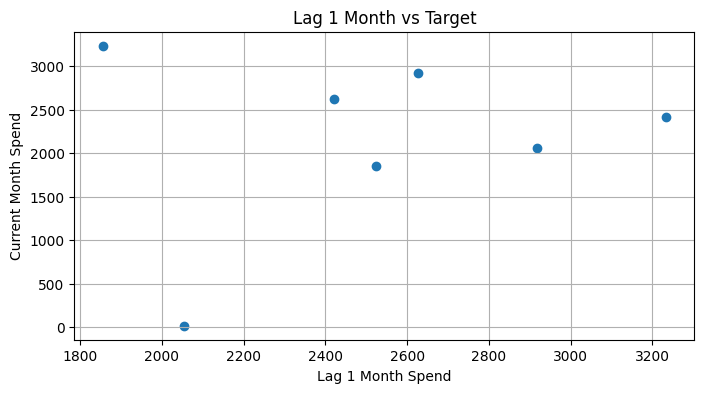

In [153]:
plt.scatter(monthly["lag_1m"], monthly["total_amount"])
plt.title("Lag 1 Month vs Target")
plt.xlabel("Lag 1 Month Spend")
plt.ylabel("Current Month Spend")
plt.grid(True)
plt.show()

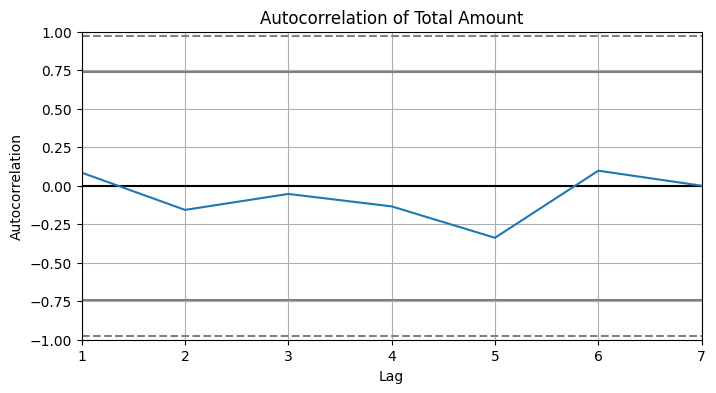

In [154]:
autocorrelation_plot(monthly["total_amount"])
plt.title("Autocorrelation of Total Amount")
plt.show()

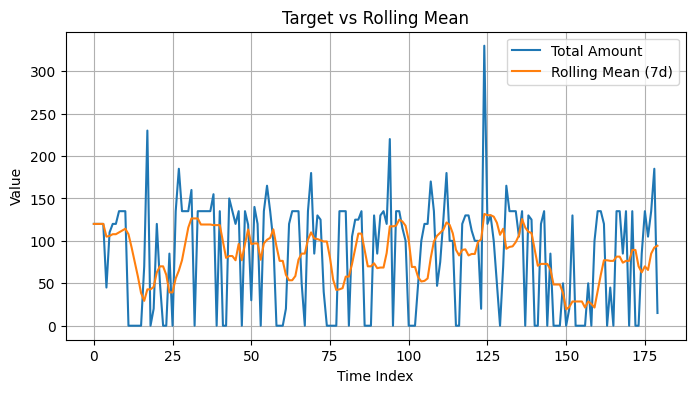

In [155]:
plt.plot(df.index, df["total_amount"], label="Total Amount")
plt.plot(df.index, df["rolling_mean_7d"], label="Rolling Mean (7d)")
plt.title("Target vs Rolling Mean")
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


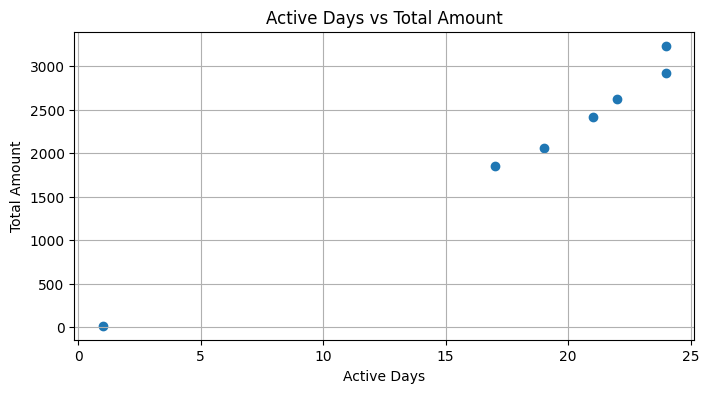

In [156]:
plt.scatter(monthly["active_days"], monthly["total_amount"])
plt.title("Active Days vs Total Amount")
plt.xlabel("Active Days")
plt.ylabel("Total Amount")
plt.grid(True)
plt.show()


In [157]:
corr = df.corr(numeric_only=True)["total_amount"].sort_values()
print(corr)

monthly

weekend                        -0.448866
holiday                        -0.206418
avg_spend_per_active_day_30d    0.134680
rolling_mean_7d                 0.342957
has_spend                       0.830038
total_amount                    1.000000
Name: total_amount, dtype: float64


,total_amount,active_days,weekend_ratio,holiday_days,rolling_mean_7d,avg_spend_intensity,lag_1m
year_month,,,,,,,
2025-08,1855.0,17,0.153846,2,81.405678,114.138812,2523.5
2025-09,3234.0,24,0.133333,0,99.752381,125.585359,1855.0
2025-10,2420.0,21,0.129032,1,80.714286,120.161962,3234.0
2025-11,2627.0,22,0.166667,2,90.304762,121.730074,2420.0
2025-12,2917.0,24,0.129032,5,96.193548,119.223104,2627.0
2026-01,2055.0,19,0.129032,1,56.843318,106.934501,2917.0
2026-02,15.0,1,1.000000,0,94.285714,106.315789,2055.0


Modeling Process

In [158]:

features = [
    "lag_1m",
    "active_days",
    "rolling_mean_7d",
    "weekend_ratio",
    "holiday_days",
]

monthly = monthly.dropna()  # lag_1m NaN
X = monthly[features]
y = monthly["total_amount"]

print(X)
print(y)
print(monthly.shape[0])

            lag_1m  active_days  rolling_mean_7d  weekend_ratio  holiday_days
year_month                                                                   
2025-08     2523.5           17        81.405678       0.153846             2
2025-09     1855.0           24        99.752381       0.133333             0
2025-10     3234.0           21        80.714286       0.129032             1
2025-11     2420.0           22        90.304762       0.166667             2
2025-12     2627.0           24        96.193548       0.129032             5
2026-01     2917.0           19        56.843318       0.129032             1
2026-02     2055.0            1        94.285714       1.000000             0
year_month
2025-08    1855.0
2025-09    3234.0
2025-10    2420.0
2025-11    2627.0
2025-12    2917.0
2026-01    2055.0
2026-02      15.0
Freq: M, Name: total_amount, dtype: float64
7


In [159]:
results = []

models = {
    "linear": LinearRegression(),
    "ridge": Ridge(alpha=1.0),
    "lasso": Lasso(alpha=0.1)
}

for i in range(3, len(monthly)):
    X_train = X.iloc[:i]
    y_train = y.iloc[:i]

    X_test = X.iloc[i:i+1]
    y_test = y.iloc[i:i+1]

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)[0]

        results.append({
            "month": df.index[i],
            "model": name,
            "actual": y_test.values[0],
            "predicted": y_pred,
            "error": abs(y_test.values[0] - y_pred),
        })

/home/johnkristanf/proj/expensepro-forecasting/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.110e+02, tolerance: 9.727e+01
  model = cd_fast.enet_coordinate_descent(


In [160]:
results_df = pd.DataFrame(results)
print(results_df)

summary = (
    results_df
    .groupby("model")["error"]
    .mean()
    .sort_values()
)

print(summary)


    month   model  actual    predicted        error
0       3  linear  2627.0  2716.580985    89.580985
1       3   ridge  2627.0  2714.720335    87.720335
2       3   lasso  2627.0  2769.061437   142.061437
3       4  linear  2917.0  3014.709043    97.709043
4       4   ridge  2917.0  3138.396960   221.396960
5       4   lasso  2917.0  2535.583670   381.416330
6       5  linear  2055.0   807.044812  1247.955188
7       5   ridge  2055.0   855.510838  1199.489162
8       5   lasso  2055.0   819.748799  1235.251201
9       6  linear    15.0 -2607.796160  2622.796160
10      6   ridge    15.0  -374.075841   389.075841
11      6   lasso    15.0 -2028.844950  2043.844950
model
ridge      474.420575
lasso      950.643479
linear    1014.510344
Name: error, dtype: float64


In [161]:
monthly["naive_pred"] = monthly["lag_1m"]
monthly["naive_error"] = abs(monthly["total_amount"] - monthly["naive_pred"])

print("Naive MAE:", monthly["naive_error"].mean())

Naive MAE: 894.3571428571429
